__Лабораторная работа №6. Рекуррентные сети__

*Выполнил: Билинский Норгей, группа 932328*

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1>

In [ ]:
# !pip install prophet
# !pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import pyarrow
import random
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных</h1>

In [ ]:
file_path = '/content/drive/My Drive/Frisson_Forecast_Procurement/materials.xlsx'

df_materials = pd.read_excel(file_path)

df_polars = pl.from_pandas(df_materials)

df_polars = df_polars.with_columns([
    pl.col("materials_data").str.strptime(pl.Date, "%d.%m.%Y").alias("materials_data")
])

df_polars


materials_data,materials_name,quantity,production_stage
date,str,f64,str
2019-07-05,"""Армировочный материал (порошок…",0.3,"""Этап производства 0000-1028.40…"
2019-07-30,"""Армировочный материал (порошок…",0.27,"""Этап производства 0000-1210.17…"
2018-10-28,"""Армировочный материал (порошок…",1.25,"""Этап производства 0000-1679.23…"
2018-11-30,"""Армировочный материал (порошок…",0.2,"""Этап производства 0000-1549.7.…"
2019-04-12,"""Армировочный материал (порошок…",0.25,"""Этап производства 0000-522.13.…"
…,…,…,…
2022-07-07,"""Круг (мат.) 40ХН2МА, 160, ГОСТ…",25.569,"""Этап производства ЗБ00-851.3.1…"
2023-08-29,"""Резец PDC 16х13 C30AH DC""",6.0,"""Этап производства ЗБ00-962.1.1…"
2022-08-23,"""Круг (мат.) 40ХН2МА, 160, ГОСТ…",42.615,"""Этап производства ЗБ00-124.2.1…"


In [ ]:
missing_values = df_polars.select([
    pl.col(column).is_null().sum().alias(column)
    for column in df_polars.columns
])

print(missing_values)


shape: (1, 4)
┌────────────────┬────────────────┬──────────┬──────────────────┐
│ materials_data ┆ materials_name ┆ quantity ┆ production_stage │
│ ---            ┆ ---            ┆ ---      ┆ ---              │
│ u32            ┆ u32            ┆ u32      ┆ u32              │
╞════════════════╪════════════════╪══════════╪══════════════════╡
│ 0              ┆ 0              ┆ 0        ┆ 0                │
└────────────────┴────────────────┴──────────┴──────────────────┘


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Предобработка данных</h1>

In [ ]:
# Отсортируем дата-фрейм по дате (от более старой к более новой)
df = df_polars.sort("materials_data")

# Получим список уникальных номенклатур материалов
unique_materials = df.select(pl.col("materials_name").unique())
unique_materials_list = unique_materials["materials_name"].to_list()
number_materials = len(unique_materials_list)
print(f'Количество уникальных материалов, используемых на производстве с 2018 по 2023 годы: {number_materials:_}')

# Закодируем длинные названия товаров 5-значным цифровым кодом
def generate_unique_code(existing_codes):
    while True:
        code = str(random.randint(10_000, 99_999))
        if code not in existing_codes:
            return code

codes_dict_materials = {}
existing_codes = set()

for material in unique_materials_list:
    code = generate_unique_code(existing_codes)
    codes_dict_materials[material] = code
    existing_codes.add(code)

# Проверка на уникальность кодов
if len(codes_dict_materials) == len(set(codes_dict_materials.values())):
    print("Все коды уникальны.")
else:
    print("Обнаружены дублирующиеся коды!")
print({k: codes_dict_materials[k] for k in list(codes_dict_materials)[:10]})

# Создание списка кодов из словаря
codes_list_materials = list(codes_dict_materials.values())
print(codes_list_materials[:10])

# Заменяем названия материалов на их коды, с указанием типа возвращаемого значения
df = df.with_columns(
    pl.col("materials_name").map_elements(lambda x: codes_dict_materials.get(x, x), return_dtype=pl.Utf8).alias("materials_name")
)

# Создадим новый дата-фрейм, где будем хранить временные ряды по всем номенклатурам материалов
date_series = pd.date_range(start="2018-01-01", end="2023-12-31", freq='D')
df_day_1 = pd.DataFrame({"date": date_series.tolist()})
df_day_2 = pd.DataFrame(columns=codes_list_materials)
df_day = pd.concat([df_day_1, df_day_2], axis=1)
# Заменим null на None
df_day = df_day.replace({np.nan: None})

# Преобразуем pandas в polars
df_day = pl.from_pandas(df_day)
# Избавимся от часов-минут-секунд в дате
df_day = df_day.with_columns(pl.col("date").cast(pl.Date).alias("date"))
# Преобразование типов данных в полях товаров в числовой формат
for col in df_day.columns:
    # Пропуская столбец "date"
    if col != "date":
        df_day = df_day.with_columns(pl.col(col).cast(pl.Float64))

num_rows = df_day.height
num_cols = df_day.width
print(f"Количество строк: {num_rows:_}")
print(f"Количество столбцов: {num_cols:_}")

missing_values = df_day.select([
    pl.col(column).is_null().sum().alias(column)
    for column in df_day.columns
])

print(missing_values)


Количество уникальных материалов, используемых на производстве с 2018 по 2023 годы: 6_672
Все коды уникальны.
{'Детали УЗБО после ТО': '16355', 'Клин К-115.13.001': '49700', 'Средство противозаклинное СПЗК-190/100.-2.001': '45904', 'Переводник бурголовки BS-123,5/67 CD 510-001.04': '51847', 'Заготовка для Переводника М-133/152.001 А': '36672', 'Лист (заг.) Лопасть 393,7 SDD 519-001.01.02.01, 1,4 (35, 50)': '34062', 'Лист (заг.) Кольцо ККП-564...592 (45, 40)': '39856', 'Лопасть калибратора КЛС-490 СТ3 (З-171М/З-171Н).07.002': '47639', 'Долото BS-123,8 SD 513-001': '12972', 'Корпус УП-133.02.001': '63465'}
['16355', '49700', '45904', '51847', '36672', '34062', '39856', '47639', '12972', '63465']
Количество строк: 2_191
Количество столбцов: 6_673
shape: (1, 6_673)
┌──────┬───────┬───────┬───────┬───┬───────┬───────┬───────┬───────┐
│ date ┆ 16355 ┆ 49700 ┆ 45904 ┆ … ┆ 79652 ┆ 75587 ┆ 32329 ┆ 39590 │
│ ---  ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ u32  ┆ u32   ┆ u32 

In [ ]:
# Функция на Pandas для занесения количества материалов из старого дата-фрейма в новый
def update_df_day(df_day, df):
    counter = 0
    for _, row in df.iterrows():
        date = row["materials_data"]
        material = row["materials_name"]
        quantity = row["quantity"]

        # Найдём индекс строки в df_day, соответствующий дате в строке df
        date_index = df_day.index[df_day["date"] == date].tolist()[0]

        # Проверим, содержит ли ячейка в df_day какое-нибудь значение
        if pd.notna(df_day.at[date_index, material]):
            # Если уже содержит, то прибавим к старому количеству дополнительное число товара
            df_day.at[date_index, material] += quantity

        else:
            # Если не содержит, то установим новое значение
            df_day.at[date_index, material] = quantity

        # Сообщение о ходе обработки
        counter += 1
        if counter % 10_000 == 0:
            print(f"{counter // 10_000} * 10 тыс. строк обработано")

    return df_day


In [ ]:
# Заполняем новый дата-фрейм
df = df.to_pandas()
df_day = df_day.to_pandas()
df_day = update_df_day(df_day, df)


1 * 10 тыс. строк обработано
2 * 10 тыс. строк обработано
3 * 10 тыс. строк обработано
4 * 10 тыс. строк обработано
5 * 10 тыс. строк обработано
6 * 10 тыс. строк обработано
7 * 10 тыс. строк обработано
8 * 10 тыс. строк обработано
9 * 10 тыс. строк обработано
10 * 10 тыс. строк обработано
11 * 10 тыс. строк обработано
12 * 10 тыс. строк обработано
13 * 10 тыс. строк обработано
14 * 10 тыс. строк обработано
15 * 10 тыс. строк обработано
16 * 10 тыс. строк обработано
17 * 10 тыс. строк обработано
18 * 10 тыс. строк обработано
19 * 10 тыс. строк обработано
20 * 10 тыс. строк обработано
21 * 10 тыс. строк обработано
22 * 10 тыс. строк обработано
23 * 10 тыс. строк обработано
24 * 10 тыс. строк обработано
25 * 10 тыс. строк обработано
26 * 10 тыс. строк обработано
27 * 10 тыс. строк обработано
28 * 10 тыс. строк обработано
29 * 10 тыс. строк обработано
30 * 10 тыс. строк обработано
31 * 10 тыс. строк обработано
32 * 10 тыс. строк обработано
33 * 10 тыс. строк обработано
34 * 10 тыс. строк 

In [ ]:
num_rows, num_cols = df_day.shape
zero_columns_count = (df_day == 0).all(axis=0).sum()
print(f"Количество строк: {num_rows:_}")
print(f"Количество столбцов: {num_cols:_}")
print("Столбцы с нулевыми значениями:", zero_columns_count)


Количество строк: 2_191
Количество столбцов: 6_673
Столбцы с нулевыми значениями: 0


In [ ]:
# Создание обратного словаря для замены шифров на названия материалов
reverse_codes_dict = {v: k for k, v in codes_dict_materials.items()}
# Замена названий столбцов
df_day.rename(columns=reverse_codes_dict, inplace=True)
# Замена всех значений NaN на 0
df_day.fillna(0, inplace=True)

file_save_path = "/content/drive/My Drive/Frisson_Forecast_Procurement/time_series_materials_day.csv"
df_day.to_csv(file_save_path)

df_day.head()


,date,Детали УЗБО после ТО,Клин К-115.13.001,Средство противозаклинное СПЗК-190/100.-2.001,"Переводник бурголовки BS-123,5/67 CD 510-001.04",Заготовка для Переводника М-133/152.001 А,"Лист (заг.) Лопасть 393,7 SDD 519-001.01.02.01, 1,4 (35, 50)","Лист (заг.) Кольцо ККП-564...592 (45, 40)",Лопасть калибратора КЛС-490 СТ3 (З-171М/З-171Н).07.002,"Долото BS-123,8 SD 513-001",...,Резец PDC 13х8 ( 1 ),"Бурголовка BS-219,1/100 CDD 813-001",Протектор резьбовой пластиковый З-152 Муфта (пробка),Ось КО-01.00.002,Заготовка для клина КГ-115.06.001 (материал УЗБО),Захват ЯГМИ-178.01.02.005,Втулка 1 ЯМН-219.01.008,Фрезер магнитный ФМ-195.001 (заготовка),Центратор нижний УРГ-120/226.01.400,"Кольцо-калибр ККП-139,7.01"
0,2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Сделаем агрегацию информации по месяцам
df_month = df_day.copy()
df_month['month'] = df_month['date'].dt.to_period('M')
df_month.drop(columns=['date'], inplace=True)
df_month = df_month.groupby('month').sum()

file_save_path = "/content/drive/My Drive/Frisson_Forecast_Procurement/time_series_materials_month.csv"
df_month.to_csv(file_save_path)

df_month.tail()


,Детали УЗБО после ТО,Клин К-115.13.001,Средство противозаклинное СПЗК-190/100.-2.001,"Переводник бурголовки BS-123,5/67 CD 510-001.04",Заготовка для Переводника М-133/152.001 А,"Лист (заг.) Лопасть 393,7 SDD 519-001.01.02.01, 1,4 (35, 50)","Лист (заг.) Кольцо ККП-564...592 (45, 40)",Лопасть калибратора КЛС-490 СТ3 (З-171М/З-171Н).07.002,"Долото BS-123,8 SD 513-001",Корпус УП-133.02.001,...,Резец PDC 13х8 ( 1 ),"Бурголовка BS-219,1/100 CDD 813-001",Протектор резьбовой пластиковый З-152 Муфта (пробка),Ось КО-01.00.002,Заготовка для клина КГ-115.06.001 (материал УЗБО),Захват ЯГМИ-178.01.02.005,Втулка 1 ЯМН-219.01.008,Фрезер магнитный ФМ-195.001 (заготовка),Центратор нижний УРГ-120/226.01.400,"Кольцо-калибр ККП-139,7.01"
month,,,,,,,,,,,,,,,,,,,,,
2023-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,197.0,0.0,0.0,8.0,0.0,4.0,0.0,0.0,0.0,0.0
2023-10,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,221.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,297.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,448.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> EDA </h1>

In [ ]:
file_path = "/content/drive/My Drive/Frisson_Forecast_Procurement/time_series_materials_day.csv"

df = pd.read_csv(file_path)
df.drop(('Unnamed: 0'), axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['total_expense'] = df.drop(columns=['date']).sum(axis=1)
df


,date,Детали УЗБО после ТО,Клин К-115.13.001,Средство противозаклинное СПЗК-190/100.-2.001,"Переводник бурголовки BS-123,5/67 CD 510-001.04",Заготовка для Переводника М-133/152.001 А,"Лист (заг.) Лопасть 393,7 SDD 519-001.01.02.01, 1,4 (35, 50)","Лист (заг.) Кольцо ККП-564...592 (45, 40)",Лопасть калибратора КЛС-490 СТ3 (З-171М/З-171Н).07.002,"Долото BS-123,8 SD 513-001",...,"Бурголовка BS-219,1/100 CDD 813-001",Протектор резьбовой пластиковый З-152 Муфта (пробка),Ось КО-01.00.002,Заготовка для клина КГ-115.06.001 (материал УЗБО),Захват ЯГМИ-178.01.02.005,Втулка 1 ЯМН-219.01.008,Фрезер магнитный ФМ-195.001 (заготовка),Центратор нижний УРГ-120/226.01.400,"Кольцо-калибр ККП-139,7.01",total_expense
0,2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2,2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060
4,2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2023-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2146.839
2187,2023-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3347.195
2188,2023-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3741.958
2189,2023-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2151.844


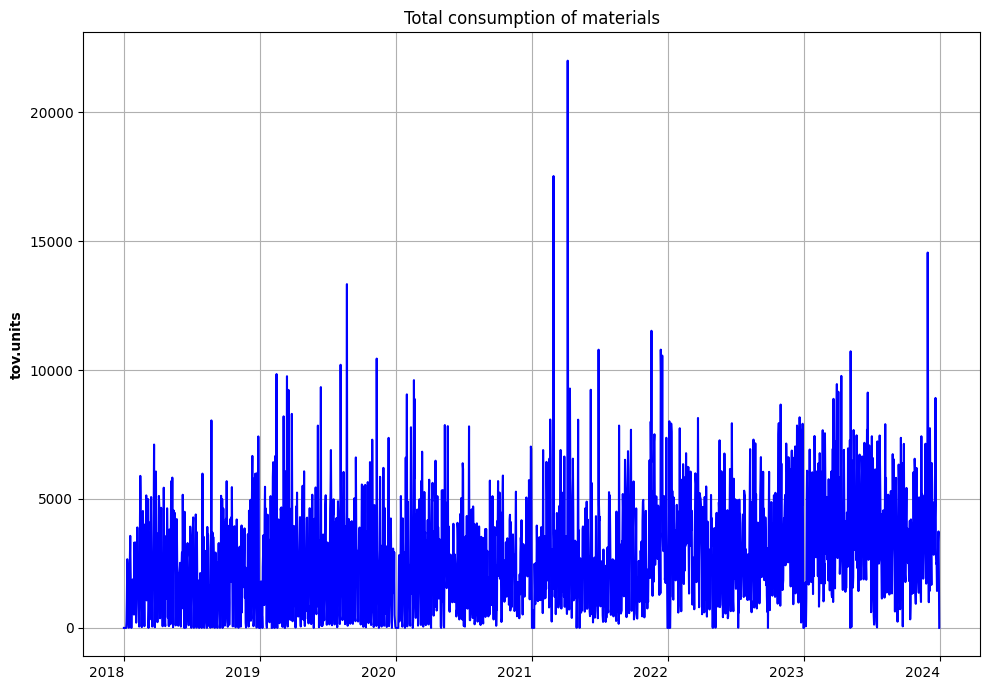

In [ ]:
# Построим график временного ряда суммарного расхода материалов по времени
# Толку от него мало, но видна активность предприятия
fig1, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(df['date'], df['total_expense'], color='blue')
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('tov.units', fontweight='bold')
ax1.set_title('Total consumption of materials')

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.setp(ax1.get_xticklabels(), rotation=0, ha='right')
plt.tight_layout()

plt.show()


In [ ]:
# Построим график временного ряда суммарного расхода материалов по времени
# Толку от него мало, но видна активность предприятия
fig = px.line(df, x='date', y='total_expense')
fig.update_layout(title_text='Total consumption of materials', title_x=0.5)
fig.update_xaxes(title_text='', rangeslider_visible=True)
fig.update_yaxes(title_text='tov.units')

fig.show()


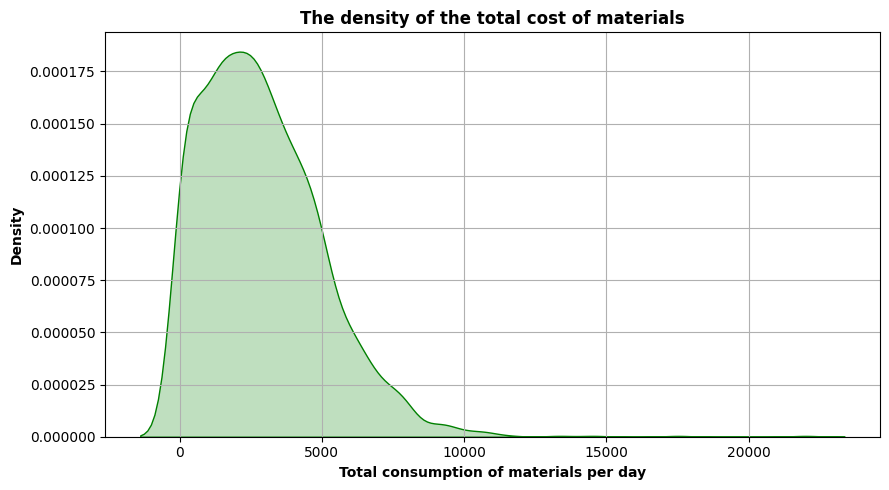

In [ ]:
# Посмотрим на то, какое общее количество материалов чаще расходуется за сутки
# Ось Y: Отображает оцененную плотность вероятности для каждого значения на оси X.

fig2, ax2 = plt.subplots(figsize=(9, 5))

sns.kdeplot(df['total_expense'], ax=ax2, color='green', fill=True)
ax2.grid(True)
ax2.set_xlabel('Total consumption of materials per day', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('The density of the total cost of materials', fontweight='bold')

plt.tight_layout()
plt.show()


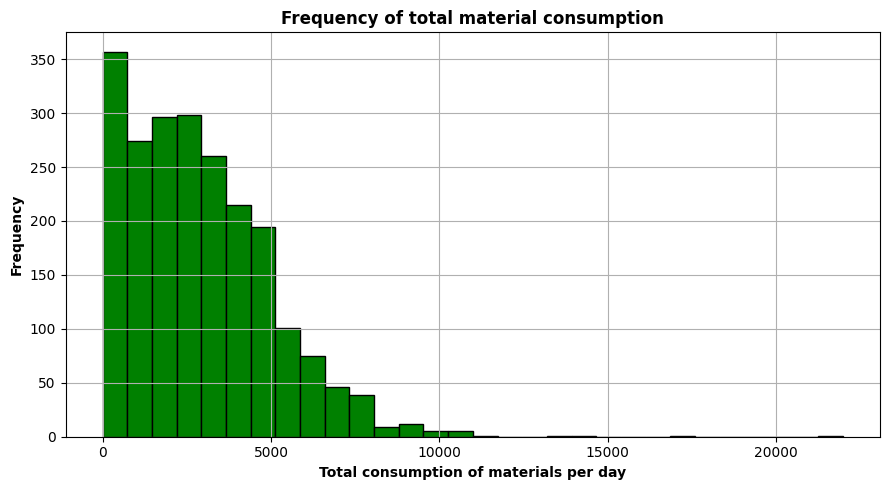

In [ ]:
# Посмотрим на то, какое общее количество материалов чаще расходуется за сутки
# Только теперь будем оперерировать не плотностью распределения, а частотой
fig3, ax3 = plt.subplots(figsize=(9, 5))

ax3.hist(df['total_expense'], bins=30, color='green', edgecolor='black')
ax3.grid(True)
ax3.set_xlabel('Total consumption of materials per day', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Frequency of total material consumption', fontweight='bold')

plt.tight_layout()
plt.show()


<ipython-input-19-dadddddde64d>:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




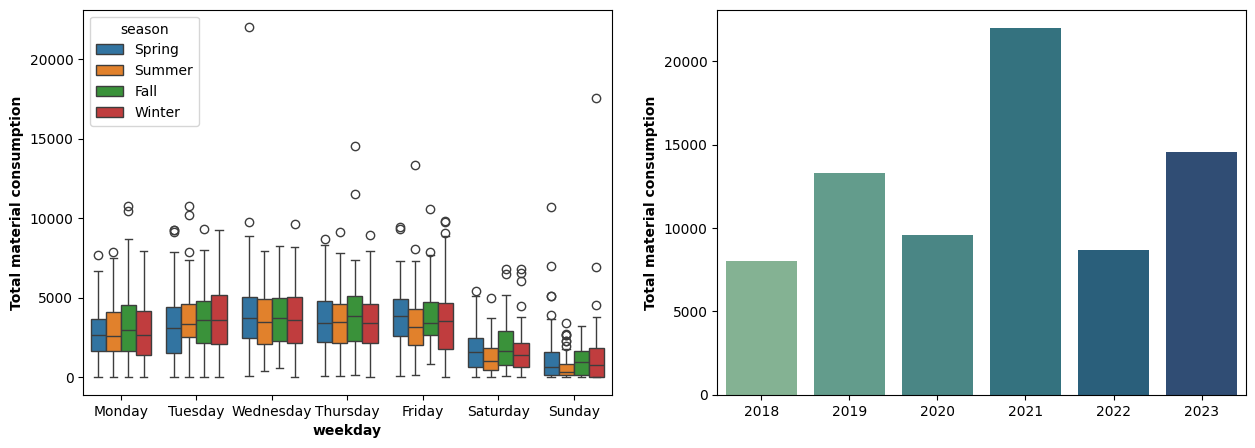

In [ ]:
# Визуализируем через боксплоты недельную/квартальную/годовую сезонности, а через барплоты - годовой тренд

def create_features(data_full, col_date):
    data = data_full.copy()
    data['weekday'] = data[col_date].dt.day_name().astype(cat_type)
    data['quarter'] = data[col_date].dt.quarter
    data['month'] = data[col_date].dt.month
    data['year'] = data[col_date].dt.year
    data['date_offset'] = (data[col_date].dt.month * 100 + data[col_date].dt.day - 320) % 1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    return data

cat_type = pd.CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

df_features = create_features(data_full=df, col_date='date')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df_features,
            x='weekday',
            y='total_expense',
            hue='season',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('weekday', fontweight='bold')
axes[0].set_ylabel('Total material consumption', fontweight='bold')

yearAggregated = pd.DataFrame(df_features.groupby("year")["total_expense"].max()).reset_index().sort_values('total_expense')
sns.barplot(data=yearAggregated, x="year", y="total_expense", palette='crest', ax=axes[1], legend=False)
axes[1].set_xlabel('')
axes[1].set_ylabel('Total material consumption', fontweight='bold')

plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk9zb86oc/j3wnz6he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk9zb86oc/cc9_pd63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30175', 'data', 'file=/tmp/tmpk9zb86oc/j3wnz6he.json', 'init=/tmp/tmpk9zb86oc/cc9_pd63.json', 'output', 'file=/tmp/tmpk9zb86oc/prophet_modelnclxmy86/prophet_model-20241015074321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


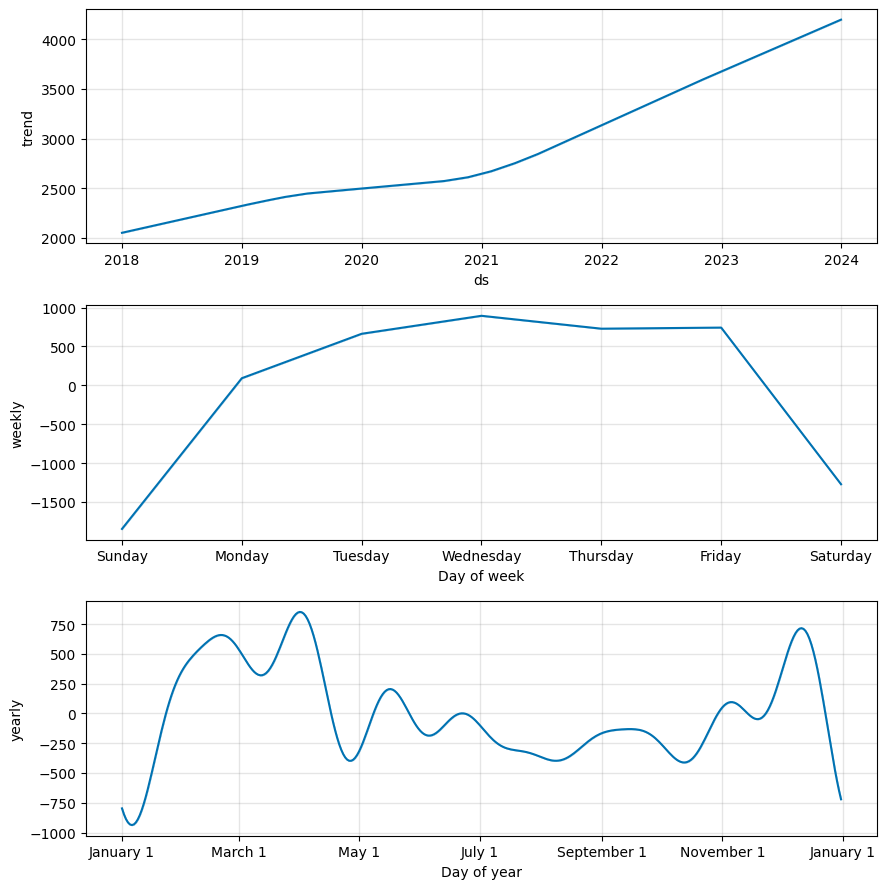

In [ ]:
# Разложение временного ряда на компоненты с помощью библиотеки Prophet
df_eda_prophet = df[['date', 'total_expense']].copy()
df_eda_prophet = df_eda_prophet.rename(columns={'date': 'ds', 'total_expense': 'y'})

model = Prophet()
model.fit(df_eda_prophet)
predict = model.predict(df_eda_prophet)

fig = model.plot_components(predict)
plt.show()


In [ ]:
# Находим суммарное потребление для каждого материала
total_consumption = df.drop(columns='date').sum().sort_values(ascending=False)
# Выбираем топ-10 материалов с наибольшим суммарным потреблением
top_10_materials = total_consumption.head(10).index
df_top = df[['date'] + list(top_10_materials)]
df_top.set_index(['date'], inplace=True)


In [ ]:
df_top.describe().T.style.background_gradient(cmap='YlOrRd')


,count,mean,std,min,25%,50%,75%,max
"Круг (мат.) 45, В1-I-115 по ГОСТ 2590-2006",2191.000000,467.826344,932.888519,0.000000,0.000000,0.000000,482.553000,7064.086000
"Круг (мат.) 45, В1-I-135 по ГОСТ 2590-2006",2191.000000,371.767382,967.979004,0.000000,0.000000,0.000000,0.000000,10241.952000
"Круг (мат.) 40ХН2МА, 220, ГОСТ 4543-2016",2191.000000,83.952205,286.877213,0.000000,0.000000,0.000000,0.000000,4229.890000
"Круг (мат.) 40ХН2МА, 230, ГОСТ 4543-2016",2191.000000,77.988405,277.317273,0.000000,0.000000,0.000000,0.000000,7017.202000
"Круг (мат.) 40ХН2МА, 300, ГОСТ 4543-2016",2191.000000,76.380415,459.990736,0.000000,0.000000,0.000000,0.000000,14377.110000
"Круг (мат.) 40ХН2МА, 140, ГОСТ 4543-2016",2191.000000,76.053022,249.815700,0.000000,0.000000,0.000000,0.000000,3189.018000
"Круг (мат.) 40ХН2МА, 120, ГОСТ 4543-2016",2191.000000,75.864190,194.250522,0.000000,0.000000,0.000000,22.107000,1952.180000
"Круг (мат.) 40ХН2МА, 160, ГОСТ 4543-2016",2191.000000,64.827498,186.955271,0.000000,0.000000,0.000000,0.000000,2288.620000
"Зубки твердосплавные Г54 , 12 х 8 , ВК8ВК",2191.000000,63.050662,134.284876,0.000000,0.000000,0.000000,53.500000,1135.000000
"Зубки твердосплавные Г5304 , ВК8",2191.000000,61.040621,69.233644,0.000000,0.000000,40.000000,92.000000,801.000000


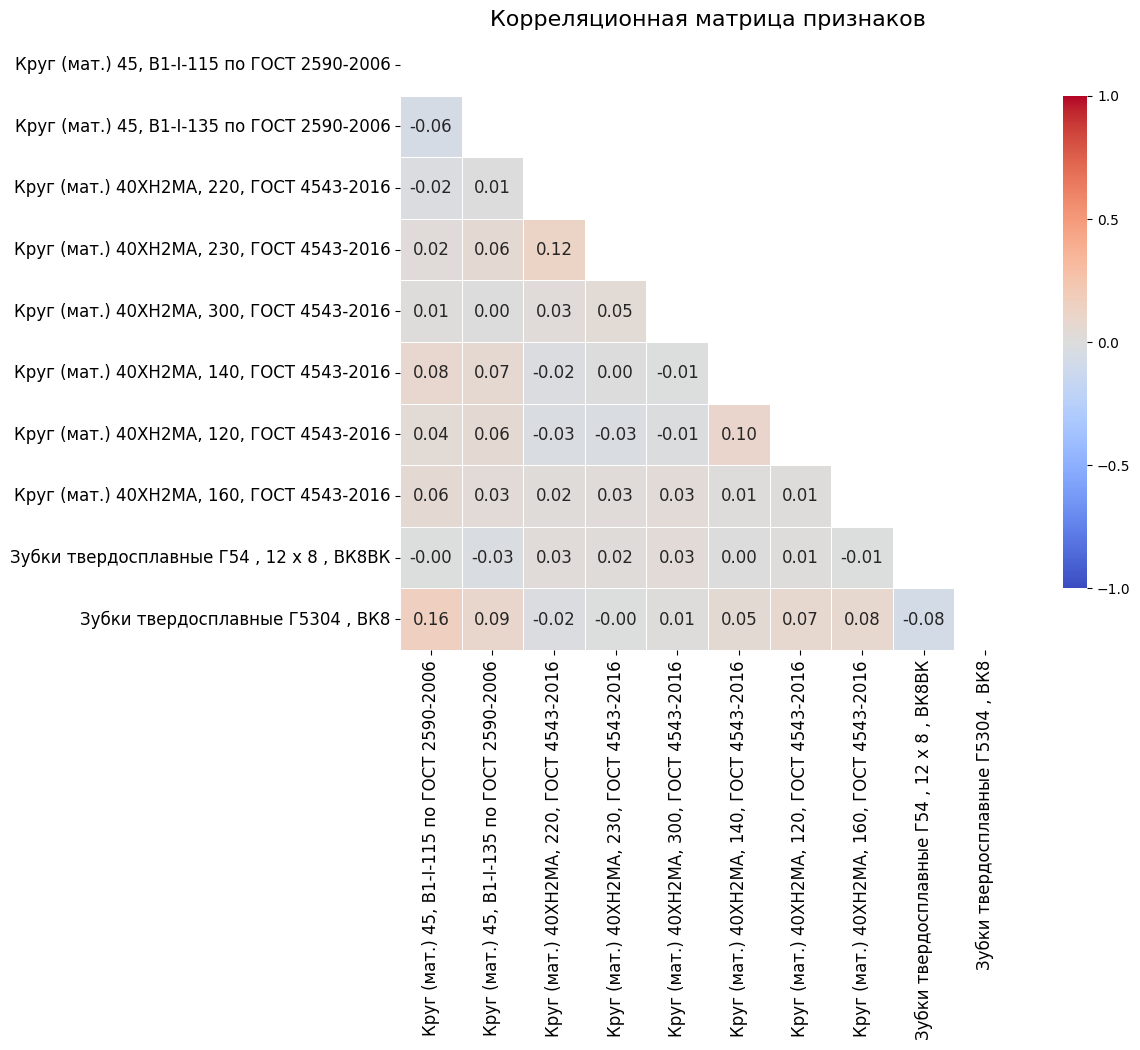

In [ ]:
corr = df_top.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot_kws={"size": 12}, fmt=".2f",
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})

plt.title('Корреляционная матрица признаков', size=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Преобразование и подготовка данных</h1>

In [147]:
# Для обучения модели возьмём временной ряд самого производимого материала
df = pd.DataFrame(df_top.iloc[:, 1].copy())
df.columns = ['target']
df.index = pd.to_datetime(df.index)


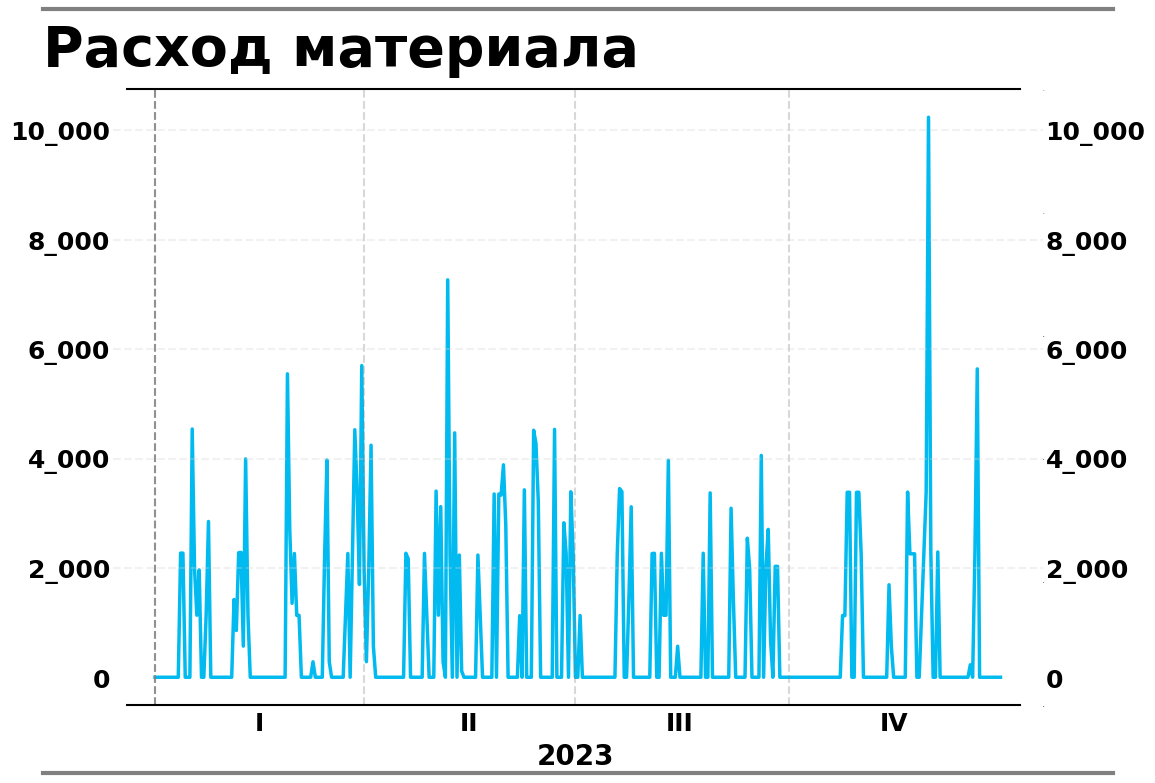

In [149]:
df_slice = df.tail(365).copy()

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(df_slice.index, df_slice['target'], color='#01BAEF', linewidth=2.5)

# Добавляем вертикальные штрих-пунктирные линии на начало каждого года
years = sorted(set(date.year for date in df_slice.index))
for year in years:
    date = datetime(year, 1, 1)
    if date >= df_slice.index.min() and date <= df_slice.index.max():
        ax1.axvline(x=date, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)
    # Добавляем вертикальные штрих-пунктирные линии на начало каждого квартала
    for month in [1, 4, 7, 10]:  # Январь, Апрель, Июль, Октябрь
        date = datetime(year, month, 1)
        if date >= df_slice.index.min() and date <= df_slice.index.max():
            ax1.axvline(x=date, color='gray', linestyle='--', linewidth=1.5, alpha=0.3)

# Настройка подписей осей Y
def percent_formatter(x, pos):
    return f'{x:_.0f}'
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax1.tick_params(axis='y', labelsize=18, length=0, pad=2)
ax2.tick_params(axis='y', labelsize=18, length=0, pad=2)
formatter = FuncFormatter(percent_formatter)
ax1.yaxis.set_major_formatter(formatter)
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
ax2.yaxis.set_major_formatter(formatter)
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
ax3 = ax1.twinx()
ax3.set_ylim(0, 1)
ax3.tick_params(axis='y', labelsize=0, length=0, pad=0)

# Добавление горизонтальных пунктирных линий
levels = range(2_000, 10_001, 2_000)
for level in levels:
    ax1.axhline(y=level, color='lightgray', linestyle='--', linewidth=1.5, alpha=0.3)

# Настройка подписей оси X
# Добавляем подписи для кварталов
ax1.tick_params(axis='x', length=0, pad=4)
quarter_starts = pd.date_range(start=df_slice.index.min(), end=df_slice.index.max(), freq='QS')
quarter_labels = {1: 'I', 4: 'II', 7: 'III', 10: 'IV'}
quarterly_labels = [f"{quarter_labels[date.month]}" for date in quarter_starts]
quarters_mid = quarter_starts + pd.DateOffset(days=45)
ax1.set_xticks(quarters_mid)
ax1.set_xticklabels(quarterly_labels, fontsize=18, fontweight='bold')
# Добавляем подписи для годов
ax4 = ax1.twiny()
ax4.yaxis.set_visible(False)
ax4.set_xlim(ax1.get_xlim())
ax4.spines['top'].set_position(('axes', -0.15))  # перемещаем ось вниз под основную
years = [datetime(year, 7, 1) for year in sorted(set(date.year for date in df_slice.index))]
ax4.set_xticks(mdates.date2num(years))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax4.tick_params(axis='x', labelsize=20, length=0, pad=20)
for label in ax4.get_xticklabels():
    label.set_fontweight('bold')

# Выделяем пограничные горизонтали графика
ax3.axhline(y=1, color='black', linewidth=1.5, clip_on=False,
            xmin=0.015, xmax=0.975)
ax3.axhline(y=0, color='black', linewidth=1.5, clip_on=False,
            xmin=0.015, xmax=0.975)

# Убираем оставшуюся рамку
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Добавляем горизонтальную линию над графиком
ax3.axhline(y=1.13, color='gray', linewidth=3, clip_on=False, xmin=-0.075, xmax=1.075)
# Добавляем горизонтальную линию под графиком
ax3.axhline(y=-0.11, color='gray', linewidth=3, clip_on=False, xmin=-0.075, xmax=1.075)

# Загружаем шрифт Arial
sans_serif_font = FontProperties(family='sans-serif', weight='bold', size=40)
# Добавляем Заголовок над графиком
ax3.text(-0.075, 1.02, 'Расход материала',
        ha="left", va="bottom", transform=ax3.transAxes,
        fontproperties=sans_serif_font)

plt.show()


In [ ]:
# Создадим новые признаки на основе временного ряда
def generate_features(df, target):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['day_of_week'] = df.index.weekday
    df['day_of_month'] = df.index.day
    df['quarter'] = df.index.quarter

    # Создание лагов для временного ряда
    for lag in range(1, 13):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)

    windows = [3, 7, 14, 30, 60, 90, 180, 365]

    # Скользящие средние
    for window in windows:
        df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window=window).mean()
    # Скользящие медианы
    for window in windows:
        df[f'{target}_rolling_median_{window}'] = df[target].rolling(window=window).median()
    # Экспоненциально сглаженные средние
    for span in windows:
        df[f'{target}_ewm_{span}'] = df[target].ewm(span=span).mean()

    df = df.dropna()

    return df

df = generate_features(df, target='target')
df



,target,year,month,week,day_of_week,day_of_month,quarter,target_lag_1,target_lag_2,target_lag_3,...,target_rolling_median_14,target_rolling_median_60,target_rolling_median_90,target_rolling_median_180,target_rolling_median_365,target_ewm_14,target_ewm_60,target_ewm_90,target_ewm_180,target_ewm_365
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.0,2018,12,1,0,31,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-01,0.0,2019,1,1,1,1,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-02,0.0,2019,1,1,2,2,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-03,0.0,2019,1,1,3,3,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04,0.0,2019,1,1,4,4,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,2023,12,52,2,27,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,512.321450,747.192771,748.543632,746.701509,741.128998
2023-12-28,0.0,2023,12,52,3,28,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,444.011924,722.694647,732.092124,738.450664,737.079088
2023-12-29,0.0,2023,12,52,4,29,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,384.810334,698.999741,716.002187,730.290988,733.051308


In [ ]:
X = df.drop(columns=['target']).copy()
y = df['target'].copy()

# Разделяем данные на тестовый (3 месяца) и тренировочный наборы
X_train = X[X.index < '2023-10-01']
X_test = X[X.index >= '2023-10-01']
y_train = y[y.index < '2023-10-01']
y_test = y[y.index >= '2023-10-01']

# Трансформируем признаки
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(f"Размер X_train: {len(X_train)}")
print(f"Размер X_test: {len(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")

# Преобразование данных в numpy массивы
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test


Размер X_train: 1735
Размер X_test: 92
Размер y_train: 1735
Размер y_test: 92


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Обучение моделей</h1>

### <h1 id="aa" style="color:white;background:#009900;padding:8px;border-radius:8px;font-family:newtimeroman;"> TensorFlow</h1>

#### <h1 id="aa" style="color:white;background:#00bfff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Baseline</h1>

In [ ]:
# Определяем размер входных данных
input_shape = (X_train_np.shape[1], 1)

# Преобразование данных для входа [samples, timesteps, features]
X_train_reshaped = np.expand_dims(X_train_np, axis=2)
X_test_reshaped = np.expand_dims(X_test_np, axis=2)

model = Sequential()

# units - это количество скрытых состояний, которые LSTM будет хранить и обновлять на каждом шаге.
# Чем больше units, тем больше информации модель сможет сохранять на каждом временном шаге

# Первый слой LSTM
model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Второй слой LSTM
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Полносвязный слой
model.add(Dense(units=50))
model.add(Dropout(0.2))

# Выходной слой
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Раннее завершение обучения при остановке улучшений
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train_np,
    epochs=100, batch_size=128,
    validation_data=(X_test_reshaped, y_test_np),
    callbacks=[early_stop]
)

loss = model.evaluate(X_test_reshaped, y_test_np)
print(f"Loss on test data: {loss}")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - loss: 1065281.3750 - val_loss: 2739581.2500
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - loss: 1274334.0000 - val_loss: 2712872.5000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 1136973.6250 - val_loss: 2686162.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 1239032.3750 - val_loss: 2657344.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 1051370.5000 - val_loss: 2628105.5000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 1143900.7500 - val_loss: 2596770.2500
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - loss: 1042343.1250 - val_loss: 2565167.7500
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 1007073.6875 - val_loss: 2535563.2500
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 1028757.0000 - val_loss: 2506590.5000
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 979618.7500 - val_loss: 2480543.5000
Epoch 11/1

In [ ]:
predictions = model.predict(X_test_reshaped)

mae = mean_absolute_error(y_test_np, predictions)
rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
r2 = r2_score(y_test_np, predictions)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE: 886.020
RMSE: 1541.739
R2: -0.021


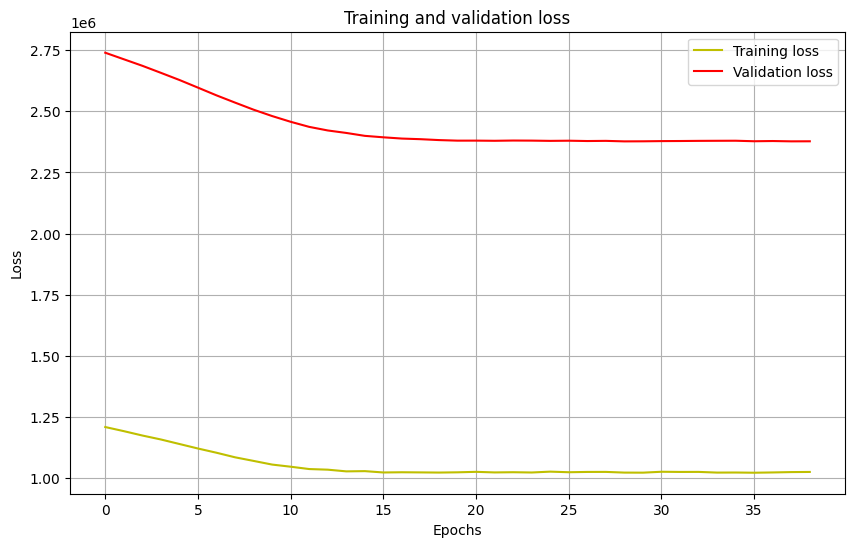

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, 'y', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### <h1 id="aa" style="color:white;background:#00bfff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Подбор гиперпараметров</h1>

In [ ]:
# Создаем модель для Optuna
def create_model(trial):
    units = trial.suggest_int('units', 50, 200)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])

    model = Sequential()

    # Первый слой LSTM
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Добавляем дополнительные слои LSTM
    for i in range(1, num_layers):
        model.add(LSTM(units=units, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(dropout_rate))

    # Полносвязный слой
    model.add(Dense(units=50))
    model.add(Dropout(dropout_rate))

    # Выходной слой
    model.add(Dense(units=1))

    # Настраиваем оптимизатор
    optimizer = Adam(learning_rate=learning_rate)

    # Компилируем модель с правильным параметром
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model, batch_size


# Определяем функцию для перебора параметров через Optuna
def objective(trial):
    model, batch_size = create_model(trial)

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train_reshaped, y_train_np,
        epochs=10, batch_size=batch_size,
        validation_data=(X_test_reshaped, y_test_np),
        callbacks=[early_stop],
        verbose=0
    )

    # Оцениваем модель на тестовых данных
    loss = model.evaluate(X_test_reshaped, y_test_np, verbose=0)

    return loss


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.params}")


[I 2024-10-15 10:36:10,285] A new study created in memory with name: no-name-80218df2-9095-4582-bb71-4507585b250a
[I 2024-10-15 10:37:01,000] Trial 0 finished with value: 2516235.25 and parameters: {'units': 148, 'num_layers': 2, 'dropout_rate': 0.4340521915248089, 'learning_rate': 0.0014573684639857475, 'batch_size': 256}. Best is trial 0 with value: 2516235.25.
[I 2024-10-15 10:37:31,200] Trial 1 finished with value: 2703755.25 and parameters: {'units': 69, 'num_layers': 2, 'dropout_rate': 0.4140069485978687, 'learning_rate': 0.0005566000728911572, 'batch_size': 256}. Best is trial 0 with value: 2516235.25.
[I 2024-10-15 10:40:09,633] Trial 2 finished with value: 2437226.5 and parameters: {'units': 178, 'num_layers': 2, 'dropout_rate': 0.17232556448913028, 'learning_rate': 0.00025917767190557006, 'batch_size': 32}. Best is trial 2 with value: 2437226.5.
[I 2024-10-15 10:43:16,032] Trial 3 finished with value: 2376977.25 and parameters: {'units': 184, 'num_layers': 3, 'dropout_rate': 

Best trial: {'units': 184, 'num_layers': 3, 'dropout_rate': 0.26398895246948684, 'learning_rate': 0.0018461626811333716, 'batch_size': 64}


In [ ]:
# Получение лучших гиперпараметров из изучения
best_params = study.best_trial.params

# Создание модели с лучшими гиперпараметрами
best_model = Sequential()

# Первый слой LSTM
best_model.add(LSTM(units=best_params['units'], return_sequences=True, input_shape=input_shape))
best_model.add(Dropout(best_params['dropout_rate']))

# Добавляем дополнительные слои LSTM
for i in range(1, best_params['num_layers']):
    best_model.add(LSTM(units=best_params['units'], return_sequences=(i < best_params['num_layers'] - 1)))
    best_model.add(Dropout(best_params['dropout_rate']))

# Полносвязный слой
best_model.add(Dense(units=50))
best_model.add(Dropout(best_params['dropout_rate']))

# Выходной слой
best_model.add(Dense(units=1))

# Настройка оптимизатора с лучшим learning_rate
optimizer = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(
    X_train_reshaped, y_train_np,
    epochs=100, batch_size=best_params['batch_size'],
    validation_data=(X_test_reshaped, y_test_np),
    callbacks=[early_stop]
)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 622ms/step - loss: 1251728.3750 - val_loss: 2624140.7500
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - loss: 1092811.0000 - val_loss: 2492605.2500
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - loss: 1083181.2500 - val_loss: 2408200.2500
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 547ms/step - loss: 989224.8125 - val_loss: 2379830.7500
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - loss: 1071906.2500 - val_loss: 2378533.5000
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - loss: 1094852.0000 - val_loss: 2380527.7500
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - loss: 1040549.6250 - val_loss: 2381583.0000
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - loss: 1076255.0000 - val_loss: 2381213.5000
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step - loss: 903830.4375 - val_loss: 2382722.2500
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/step - loss: 977640.1250 - val_loss: 2375212.2500
Ep

In [ ]:
predictions = best_model.predict(X_test_reshaped)

mae = mean_absolute_error(y_test_np, predictions)
rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
r2 = r2_score(y_test_np, predictions)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
MAE: 892.960
RMSE: 1539.975
R2: -0.018


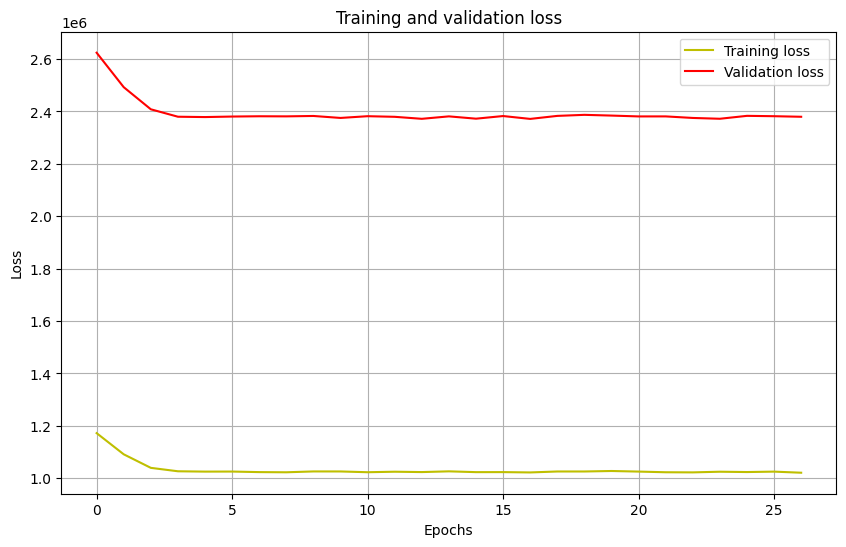

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, 'y', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


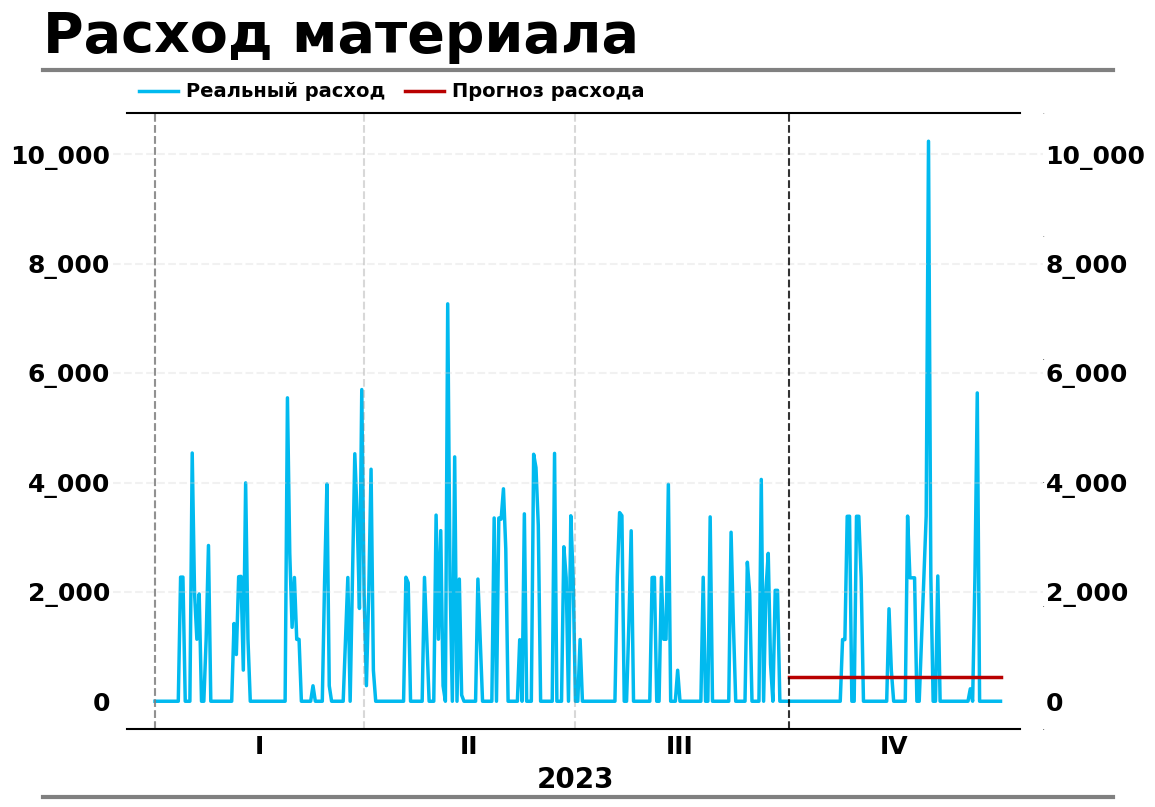

In [146]:
predictions_df = pd.DataFrame(predictions, columns=['predicted'], index=df_slice.index[-len(predictions):])
result_df = df_slice.copy()
result_df = result_df.join(predictions_df)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Реальные данные
ax1.plot(result_df.index, result_df['target'], color='#01BAEF', linewidth=2.5, label='Real Data')
# Прогнозные данные
ax1.plot(result_df.index, result_df['predicted'], color='#B90000', linewidth=2.5, label='Predictions')

# Добавляем легенду
legend_tickers = ['Реальный расход', 'Прогноз расхода']
legend = ax1.legend(
    legend_tickers,
    loc='lower center',
    bbox_to_anchor=(0.3, 1.035),
    ncol=6,
    fontsize=14,
    frameon=False,
    borderaxespad=-0.9,
    shadow=True,
    handletextpad=0.4,
    columnspacing=1.0)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Добавление горизонтальных пунктирных линий
levels = range(2_000, 10_001, 2_000)
for level in levels:
    ax1.axhline(y=level, color='lightgray', linestyle='--', linewidth=1.5, alpha=0.3)

# Добавляем вертикальные штрих-пунктирные линии на начало каждого года
years = sorted(set(date.year for date in result_df.index))
for year in years:
    date = datetime(year, 1, 1)
    if date >= result_df.index.min() and date <= result_df.index.max():
        ax1.axvline(x=date, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)
    # Добавляем вертикальные штрих-пунктирные линии на начало каждого квартала
    for month in [1, 4, 7, 10]:  # Январь, Апрель, Июль, Октябрь
        if month == 10:
            date = datetime(year, month, 1)
            if date >= result_df.index.min() and date <= result_df.index.max():
                ax1.axvline(x=date, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
        else:
            date = datetime(year, month, 1)
            if date >= result_df.index.min() and date <= result_df.index.max():
                ax1.axvline(x=date, color='gray', linestyle='--', linewidth=1.5, alpha=0.3)

# Настройка подписей осей Y
def percent_formatter(x, pos):
    return f'{x:_.0f}'
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax1.tick_params(axis='y', labelsize=18, length=0, pad=2)
ax2.tick_params(axis='y', labelsize=18, length=0, pad=2)
formatter = FuncFormatter(percent_formatter)
ax1.yaxis.set_major_formatter(formatter)
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
ax2.yaxis.set_major_formatter(formatter)
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
ax3 = ax1.twinx()
ax3.set_ylim(0, 1)
ax3.tick_params(axis='y', labelsize=0, length=0, pad=0)

# Настройка подписей оси X
# Добавляем подписи для кварталов
ax1.tick_params(axis='x', length=0, pad=4)
quarter_starts = pd.date_range(start=result_df.index.min(), end=result_df.index.max(), freq='QS')
quarter_labels = {1: 'I', 4: 'II', 7: 'III', 10: 'IV'}
quarterly_labels = [f"{quarter_labels[date.month]}" for date in quarter_starts]
quarters_mid = quarter_starts + pd.DateOffset(days=45)
ax1.set_xticks(quarters_mid)
ax1.set_xticklabels(quarterly_labels, fontsize=18, fontweight='bold')
# Добавляем подписи для годов
ax4 = ax1.twiny()
ax4.yaxis.set_visible(False)
ax4.set_xlim(ax1.get_xlim())
ax4.spines['top'].set_position(('axes', -0.15))  # перемещаем ось вниз под основную
years = [datetime(year, 7, 1) for year in sorted(set(date.year for date in result_df.index))]
ax4.set_xticks(mdates.date2num(years))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax4.tick_params(axis='x', labelsize=20, length=0, pad=20)
for label in ax4.get_xticklabels():
    label.set_fontweight('bold')

# Выделяем пограничные горизонтали графика
ax3.axhline(y=1, color='black', linewidth=1.5, clip_on=False,
            xmin=0.015, xmax=0.975)
ax3.axhline(y=0, color='black', linewidth=1.5, clip_on=False,
            xmin=0.015, xmax=0.975)

# Убираем оставшуюся рамку
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Добавляем горизонтальную линию над графиком
ax3.axhline(y=1.07, color='gray', linewidth=3, clip_on=False, xmin=-0.075, xmax=1.075)
# Добавляем горизонтальную линию под графиком
ax3.axhline(y=-0.11, color='gray', linewidth=3, clip_on=False, xmin=-0.075, xmax=1.075)

# Загружаем шрифт Inter
sans_serif_font = FontProperties(family='sans-serif', weight='bold', size=40)
# Добавляем Заголовок над графиком
ax3.text(-0.075, 1.08, 'Расход материала',
        ha="left", va="bottom", transform=ax3.transAxes,
        fontproperties=sans_serif_font)

plt.show()


In [134]:
df_slice[df_slice['target']>0]


,target
date,
2023-01-12,2270.000
2023-01-13,2270.000
2023-01-17,4539.640
2023-01-18,1985.935
2023-01-19,1134.250
...,...
2023-12-01,2291.104
2023-12-04,2291.104
2023-12-18,228.000


### <h1 id="aa" style="color:white;background:#009900;padding:8px;border-radius:8px;font-family:newtimeroman;"> PyTorch</h1>

#### <h1 id="aa" style="color:white;background:#00bfff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Baseline</h1>

In [ ]:
# Определение модели LSTM на PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out[:, -1, :])  # Используем последний временной шаг
        x = self.fc(x)
        return x

# Определение параметров
input_size = 1
hidden_size = 100
output_size = 1
num_layers = 2
dropout = 0.2
learning_rate = 0.001
epochs = 100
batch_size = 128

# Преобразование данных для входа [samples, timesteps, features]
X_train_reshaped = np.expand_dims(X_train_np, axis=2)
X_test_reshaped = np.expand_dims(X_test_np, axis=2)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()

    # Прямой проход
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Обратное распространение и оптимизация
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    # Оценка на валидационном наборе
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch 1/100, Loss: 1211124.3750, Val Loss: 2757276.2500
Epoch 2/100, Loss: 1211089.1250, Val Loss: 2757225.0000
Epoch 3/100, Loss: 1211057.2500, Val Loss: 2757172.2500
Epoch 4/100, Loss: 1211021.5000, Val Loss: 2757116.2500
Epoch 5/100, Loss: 1210984.6250, Val Loss: 2757054.5000
Epoch 6/100, Loss: 1210943.1250, Val Loss: 2756983.7500
Epoch 7/100, Loss: 1210897.8750, Val Loss: 2756901.0000
Epoch 8/100, Loss: 1210842.6250, Val Loss: 2756800.0000
Epoch 9/100, Loss: 1210778.2500, Val Loss: 2756671.2500
Epoch 10/100, Loss: 1210687.7500, Val Loss: 2756501.7500
Epoch 11/100, Loss: 1210580.1250, Val Loss: 2756264.7500
Epoch 12/100, Loss: 1210427.1250, Val Loss: 2755922.5000
Epoch 13/100, Loss: 1210198.7500, Val Loss: 2755430.2500
Epoch 14/100, Loss: 1209873.7500, Val Loss: 2754786.5000
Epoch 15/100, Loss: 1209451.1250, Val Loss: 2754074.5000
Epoch 16/100, Loss: 1208984.3750, Val Loss: 2753394.5000
Epoch 17/100, Loss: 1208530.3750, Val Loss: 2752782.0000
Epoch 18/100, Loss: 1208136.8750, Val Lo

In [ ]:
# Оценка модели на тестовых данных
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

mae = mean_absolute_error(y_test_np, predictions)
rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
r2 = r2_score(y_test_np, predictions)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')


MAE: 662.623
RMSE: 1654.369
R2: -0.175


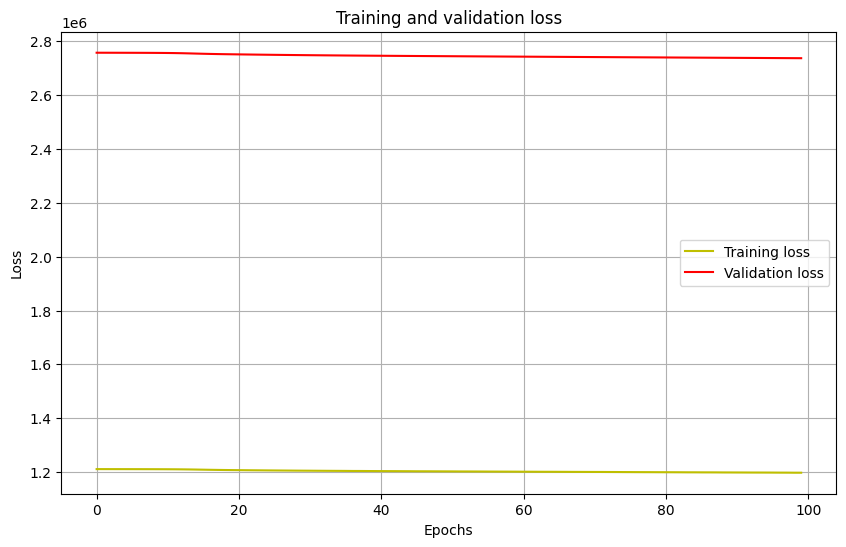

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, 'y', label='Training loss')
plt.plot(val_loss_history, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
